In [1]:
%reload_ext autoreload
%autoreload 2

from fastai import *
from fastai.vision import *
from pathlib import Path
import PIL
import cv2

from utils import *
from dark import *
from wrn4 import *

torch.backends.cudnn.benchmark = False

In [2]:
MASKS = 'train.csv'

PATH = Path('./')

TRAIN = Path('train/')
TRAIN64 = Path('train64/')

TEST = Path('test/')

SAMPLE = Path('sample_submission.csv')

seg = pd.read_csv(PATH/MASKS)
sample_sub = pd.read_csv(PATH/SAMPLE)
train_names = list(seg.Id.values)
test_names = list(sample_sub.Id.values)

In [3]:
arch = Darknet([1,2,8,8,4], 28, 32, se=True)
# arch = wrn_22_10()

In [4]:
def open_image4d(path:PathOrStr)->Image:
    '''open RGBA image from 4 different 1-channel files.
    return: numpy array [4, sz, sz]'''
    path=str(path)
    flags = cv2.IMREAD_GRAYSCALE
    red = cv2.imread(path+ '_red.png', flags)
    blue = cv2.imread(path+ '_blue.png', flags)
    green = cv2.imread(path+ '_green.png', flags)
    yellow = cv2.imread(path+ '_yellow.png', flags)
    im = np.stack(([red, green, blue, yellow]))

    return Image(Tensor(im/255).float())

# def open_image4d(path:PathOrStr)->Image:
#     '''open RGBA image from a single 4-channel file
#     return: numpy array [4, sz, sz]'''
#     path=str(path)
#     flags = cv2.IMREAD_UNCHANGED
#     im = cv2.imread(path+ '.png', flags)
#     return Image(Tensor(np.rollaxis(im, 2, 0)/255).float())


In [5]:
fname = train_names[0]

In [6]:
%time im = open_image4d(TRAIN/fname); 

CPU times: user 16.9 ms, sys: 227 µs, total: 17.1 ms
Wall time: 19.3 ms


In [7]:
im.shape

torch.Size([4, 512, 512])

In [8]:
class Image4C_ds(ImageMultiDataset):
    def __init__(self, fns:FilePathList, labels:ImgLabels, classes:Optional[Collection[Any]]=None):
        super().__init__(fns, labels, classes)
    def __getitem__(self,i:int)->Tuple[Image, np.ndarray]: return open_image4d(self.x[i]), self.encode(self.y[i])
    def _get_x(self,i): return open_image4d(self.x[i])

In [9]:
from fastai.data_block import _extract_input_labels
fnames, labels = _extract_input_labels(seg, label_delim=' ')
test_fnames, _ = _extract_input_labels(sample_sub)

In [10]:
classes = uniqueify(np.concatenate(labels))

In [11]:
stats = ([0.485, 0.456, 0.406, 0.406], [0.229, 0.224, 0.225, 0.225])
norm,denorm = normalize_funcs(*stats)

In [12]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.2)

In [13]:
def get_data(sz=64, bs=64, is_test=False, pct = 0.2):
    folder=TRAIN
    test_ds=None
    if is_test: 
        t_names = [TEST/f for f in test_names]
        test_labels = [[classes[0]]] * len(test_names)
        test_ds = Image4C_ds(t_names, test_labels, classes)
    train, val = Image4C_ds.from_folder(PATH, folder, fnames, labels, valid_pct=pct, classes=classes)
    return ImageDataBunch.create(train_ds=train, valid_ds=val, test_ds=test_ds,
                                 ds_tfms=tfms, tfms=norm, bs=bs, size=sz)


In [14]:
# train, val = Image4C_ds.from_folder(PATH, TRAIN, fnames, labels, valid_pct=0.2, classes=classes)

In [15]:
class_sample_count = array([12885,  1254,  3621,  1561,  1858,  2513,  1008,  2822,    53,
          45,    28,  1093,   688,   537,  1066,    21,   530,   210,
         902,  1482,   172,  3777,   802,  2965,   322,  8228,   328,
          11])
print(class_sample_count)

[12885  1254  3621  1561  1858  2513  1008  2822    53    45    28  1093   688   537  1066    21   530   210   902
  1482   172  3777   802  2965   322  8228   328    11]


In [16]:
def get_learner(data, focal=False, fp16=False):
    learn = Learner(data, arch , metrics=[accuracy_thresh, f1], loss_func=FocalLoss())
#     if focal: learn.loss_func=FocalLoss()
    if fp16: learn.to_fp16();
    return learn.mixup(stack_y=False)

# 64

In [78]:
data = get_data(64, 160, True)
learn = get_learner(data, focal=True, fp16=True)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


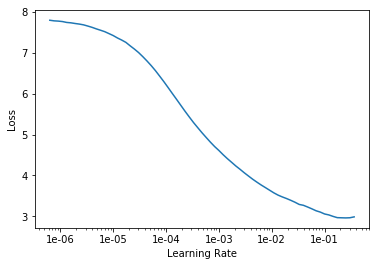

In [23]:
learn.lr_find()
learn.recorder.plot()

In [94]:
lr=1e-3

In [27]:
%time learn.fit_one_cycle(50, lr, wd=0.2, div_factor=10, pct_start=0.5)

Total time: 1:24:42
epoch  train_loss  valid_loss  accuracy_thresh  f1      
1      1.176282    1.316651    0.941974         0.028383  (01:43)
2      1.107380    1.418477    0.944296         0.276390  (01:40)
3      1.080250    1.258460    0.947521         0.237161  (01:39)
4      1.074404    1.255535    0.947003         0.145821  (01:43)
5      1.063944    1.245661    0.946676         0.194384  (01:43)
6      1.042003    1.233742    0.945463         0.191010  (01:38)
7      1.030594    1.164250    0.948658         0.286968  (01:41)
8      1.005721    1.181208    0.947337         0.274912  (01:41)
9      0.994702    1.357218    0.945245         0.221916  (01:39)
10     0.977545    2.254323    0.928215         0.259994  (01:44)
11     0.964405    1.143348    0.948762         0.249196  (01:41)
12     0.951104    1.268850    0.945923         0.367395  (01:43)
13     0.939000    1.068871    0.952986         0.393463  (01:43)
14     0.922197    1.170051    0.950538         0.372349  (01:41)

In [28]:
learn.save('dk_se_64')

# 128

In [25]:
data = get_data(128, 64, True)
learn = get_learner(data, focal=True, fp16=True)

In [30]:
learn.load('dk_se_64')

In [31]:
%time learn.fit_one_cycle(30, lr/3, wd=0.2, div_factor=10, pct_start=0.5)

Total time: 2:24:29
epoch  train_loss  valid_loss  accuracy_thresh  f1      
1      0.684365    0.661110    0.967953         0.633298  (04:57)
2      0.684781    0.648089    0.968568         0.646160  (04:47)
3      0.662372    0.647004    0.968417         0.647480  (04:48)
4      0.659158    0.690599    0.966572         0.612744  (04:48)
5      0.667445    0.665199    0.967908         0.644552  (04:48)
6      0.665292    0.693984    0.966309         0.614482  (04:47)
7      0.661301    0.679568    0.967120         0.639897  (04:47)
8      0.661558    0.708587    0.966052         0.614071  (04:48)
9      0.663646    0.689065    0.967002         0.643544  (04:48)
10     0.658326    0.718414    0.966008         0.642097  (04:47)
11     0.664476    0.755450    0.964660         0.606294  (04:48)
12     0.653408    0.735442    0.965398         0.599422  (04:48)
13     0.664875    0.751789    0.965214         0.604851  (04:49)
14     0.659697    0.885082    0.961608         0.547105  (04:47)

In [32]:
learn.save('dk_se_128')

# 256

In [87]:
data = get_data(256, 24, True, 0.05)
learn = get_learner(data, focal=True, fp16=True)

In [88]:
learn.load('dk_se_256_v2');

In [26]:
%time learn.fit_one_cycle(10, 1e-3/10, wd=0.2, div_factor=10, pct_start=0.5)

Total time: 3:57:48
epoch  train_loss  valid_loss  accuracy_thresh  f1      
1      0.533073    0.475069    0.976439         0.767298  (23:45)
2      0.541550    0.479692    0.976303         0.764701  (23:49)
3      0.553046    0.498948    0.975061         0.749477  (23:42)
4      0.563453    0.577383    0.972102         0.708697  (23:41)
5      0.582180    0.567639    0.972102         0.721673  (23:43)
6      0.573026    0.580657    0.971401         0.727293  (23:50)
7      0.565164    0.528148    0.973841         0.742318  (23:47)
8      0.526071    0.502509    0.974993         0.754637  (23:49)
9      0.511492    0.483324    0.976281         0.766510  (23:48)
10     0.486939    0.480493    0.976394         0.770490  (23:49)

CPU times: user 2h 5min 29s, sys: 1h 51min 42s, total: 3h 57min 12s
Wall time: 3h 57min 48s


In [27]:
learn.save('dk_se_256_v2');

In [92]:
data = get_data(256, 24, True, 0.05)
learn = get_learner(data, focal=True, fp16=False)
learn.model.float();
learn.load('dk_se_256_v2');

In [98]:
p, t = learn.TTA(ds_type=DatasetType.Test)

Total time: 22:14



# 512

In [110]:
data = get_data(508, 8, True, 0)

In [113]:
learn = get_learner(data, focal=True, fp16=True)

RuntimeError: cuda runtime error (77) : an illegal memory access was encountered at /opt/conda/conda-bld/pytorch-nightly_1541670623625/work/aten/src/THC/THCTensorCopy.cu:205

In [109]:
learn.load('dk_se_256_v2');

RuntimeError: cuda runtime error (77) : an illegal memory access was encountered at /opt/conda/conda-bld/pytorch-nightly_1541670623625/work/aten/src/THC/generic/THCTensorCopy.cpp:20

In [106]:
learn.fit_one_cycle(5, 1e-5)

epoch,train_loss,valid_loss,accuracy_thresh,f1


RuntimeError: cuda runtime error (77) : an illegal memory access was encountered at /opt/conda/conda-bld/pytorch-nightly_1541670623625/work/aten/src/THC/generic/THCTensorMath.cu:24

In [22]:
learn.save('dk_se_512_v2')

# Validation and Preds

In [64]:
data = get_data(500, 16, True)
learn = get_learner(data, focal=True, fp16=False)

In [65]:
learn.load('dk_se_512_v2');

In [66]:
learn.model.float();

In [77]:
p1,t1 = learn.get_preds(ds_type=DatasetType.Test)

KeyboardInterrupt: 

In [68]:
p,t = learn.TTA(ds_type=DatasetType.Test)

Total time: 1:25:22



In [25]:
#valid data
# learn.data.valid_dl.add_tfm(to_half)
p_v, t_v = learn.get_preds()

In [71]:
np.save("preds500", to_np(p))

In [26]:
p_v.shape

torch.Size([1586, 28])

In [27]:
def f1_np(y_pred, y_true, threshold=0.5):
    y_pred = (y_pred>threshold).astype(int)
    TP = (y_pred*y_true).sum(1)
    prec = TP/(y_pred.sum(1)+1e-7)
    rec = TP/(y_true.sum(1)+1e-7)
    res = 2*prec*rec/(prec+rec+1e-7)
    return res.mean()

In [28]:
p_v_s = p_v.sigmoid()

In [29]:
f1(p_v, t_v)

tensor(0.6284)

In [30]:
p_v_np, t_v_np = to_np(p_v_s), to_np(t_v)

In [31]:
f1_np(p_v_np, t_v_np)

0.6283701845350824

In [32]:
def f1_n(y_pred, y_true, thresh, n, default=0.5):
    threshold = default * np.ones(y_pred.shape[1])
    threshold[n]=thresh
    return f1_np(y_pred, y_true, threshold)

In [33]:
def find_thresh(y_pred, y_true):
    ths = []
    for i in range(y_pred.shape[1]):
        aux = []
        for th in np.linspace(0,1,100):
            aux += [f1_n(y_pred, y_true, th, i)]
        ths += [np.array(aux).argmax()/100]
    return np.array(ths)

In [34]:
x = np.linspace(0,1,100)

In [35]:
y = np.array([f1_n(p_v_np, t_v_np, th, 1) for th in x])

In [36]:
import matplotlib.pyplot as plt

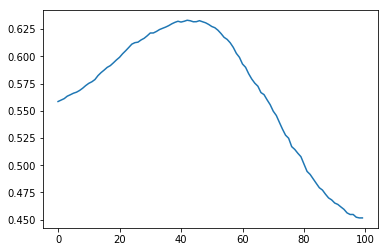

In [37]:
plt.plot(y)

In [41]:
ths = find_thresh(p_v_np, t_v_np); ths

array([0.61, 0.42, 0.36, 0.4 , 0.35, 0.43, 0.4 , 0.3 , 0.38, 0.26, 0.28, 0.36, 0.29, 0.38, 0.49, 0.55, 0.29, 0.51,
       0.27, 0.31, 0.48, 0.41, 0.2 , 0.46, 0.38, 0.73, 0.16, 0.4 ])

In [72]:
ths=array([0.56, 0.36, 0.48, 0.47, 0.47, 0.4 , 0.42, 0.41, 0.37, 0.36, 0.42, 0.48, 0.43, 0.49, 0.66, 0.37, 0.56, 0.31,
       0.26, 0.53, 0.71, 0.36, 0.24, 0.33, 0.29, 0.33, 0.33, 0.47])



In [42]:
f1_np(p_v_np, t_v_np, ths)

0.7020946345612924

# Sub File

In [99]:
preds = to_np(p.sigmoid())
threshold = ths
print(preds.shape)
classes = np.array(classes)
res = np.array([" ".join(classes[(np.where(pp>threshold))])for pp in preds])

(11702, 28)


In [100]:
classes

array(['16', '0', '7', '1', '2', '5', '18', '25', '23', '21', '24', '6', '11', '3', '12', '13', '14', '4', '20', '22',
       '17', '19', '8', '9', '10', '26', '27', '15'], dtype='<U2')

In [101]:
frame = pd.DataFrame(np.array([test_names, res]).T, columns = ['Id','Predicted'])
frame.to_csv('protein_se.csv', index=False)

In [102]:
frame.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,5
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 25
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,23
